##1. Data Collection & HTML Parsing (15%)

In [ ]:
import pandas as pd


df = pd.read_excel('data/urls.xlsx')


print(df.head())

   Unnamed: 0                                                url
0           0     https://www.cm-alliance.com/cybersecurity-blog
1           1    https://www.varonis.com/blog/cybersecurity-tips
2           2  https://www.cisecurity.org/insights/blog/11-cy...
3           3  https://www.cisa.gov/topics/cybersecurity-best...
4           4  https://www.qnbtrust.bank/Resources/Learning-C...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  81 non-null     int64 
 1   url         81 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


 Installing necessary libraries for web scraping the url




In [ ]:
%pip install requests beautifulsoup4


Creating functions for fetching HTML content from a URL with error handling and delays, and for extracting title and body text from HTML.


In [24]:
import requests
from bs4 import BeautifulSoup
import time


def fetch_html(url, headers, retries=3, delay=3):
    """Fetches HTML content from a URL with error handling and delays."""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
            return response.text
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1} failed for {url}: {e}")
            if attempt < retries - 1:
                time.sleep(delay)
            else:
                return None


def extract_title_and_body(html):
    """Extracts title and body text from HTML."""
    if not html:
        return None, None

    soup = BeautifulSoup(html, 'html.parser')

    title = soup.title.string if soup.title else None

    body = None
    main_content_tags = ['article', 'main', 'div', 'body']
    for tag_name in main_content_tags:
        tag = soup.find(tag_name)
        if tag:
            body = tag.get_text(separator='\n', strip=True)
            break

    return title, body

In [25]:
extracted_titles = []
extracted_bodies = []
extracted_urls = []

for index, row in df.iterrows():
    url = row['url']
    html_content = fetch_html(url, HEADERS)

    if html_content:
        title, body = extract_title_and_body(html_content)
        extracted_titles.append(title)
        extracted_bodies.append(body)
        extracted_urls.append(url)
    else:
        extracted_titles.append(None)
        extracted_bodies.append(None)
        extracted_urls.append(url)


Attempt 1 failed for https://www.connectwise.com/blog/phishing-prevention-tips: 403 Client Error: Forbidden for url: https://www.connectwise.com/blog/phishing-prevention-tips
Attempt 2 failed for https://www.connectwise.com/blog/phishing-prevention-tips: 403 Client Error: Forbidden for url: https://www.connectwise.com/blog/phishing-prevention-tips
Attempt 3 failed for https://www.connectwise.com/blog/phishing-prevention-tips: 403 Client Error: Forbidden for url: https://www.connectwise.com/blog/phishing-prevention-tips
Attempt 1 failed for https://www.hpe.com/us/en/what-is/sd-wan.html: HTTPSConnectionPool(host='www.hpe.com', port=443): Read timed out. (read timeout=10)
Attempt 2 failed for https://www.hpe.com/us/en/what-is/sd-wan.html: HTTPSConnectionPool(host='www.hpe.com', port=443): Read timed out. (read timeout=10)
Attempt 3 failed for https://www.hpe.com/us/en/what-is/sd-wan.html: HTTPSConnectionPool(host='www.hpe.com', port=443): Read timed out. (read timeout=10)
Attempt 1 failed

In [26]:
extracted_df_cleaned = extracted_df.dropna()
print("DataFrame after removing null values:")
display(extracted_df_cleaned.head())
print(f"\nNumber of rows after removing null values: {len(extracted_df_cleaned)}")

DataFrame after removing null values:


,url,title,body,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Back Training NCSC Assured Cyber Incident Plan...,535.0
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1700.0
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058.0
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826.0
4,https://www.qnbtrust.bank/Resources/Learning-C...,\r\n\t7 Cyber Security Tips\r\n,,0.0



Number of rows after removing null values: 71


In [31]:
import re

cleaned_bodies = []
word_counts = []

for body in extracted_bodies:
    if body is not None:
        # Remove HTML tags
        cleaned_text = re.sub(r'<.*?>', '', body)
        # Remove extra whitespace
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        # Calculate word count
        word_count = len(cleaned_text.split()) if cleaned_text else 0
        cleaned_bodies.append(cleaned_text)
        word_counts.append(word_count)
    else:
        cleaned_bodies.append(None)
        word_counts.append(None)


In [32]:
data = {
    'url': extracted_urls,
    'title': extracted_titles,
    'body': cleaned_bodies
}

extracted_df = pd.DataFrame(data)
extracted_df['word_count'] = word_counts

extracted_df.to_csv("extracted_df_cleaned.csv", index=False)

In [42]:
import pandas as pd

df_cleaned = pd.read_csv('extracted_df_cleaned.csv')
display(df_cleaned.head())

,url,title,body,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Back Training NCSC Assured Cyber Incident Plan...,535.0
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1700.0
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058.0
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826.0
4,https://www.qnbtrust.bank/Resources/Learning-C...,\r\n\t7 Cyber Security Tips\r\n,NaN,0.0


##2. Text Preprocessing & Feature Engineering (25%)

In [44]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('book')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | D

True

In [40]:
%pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.3 MB/s eta 0:00:00


In [45]:
from nltk.tokenize import sent_tokenize
import textstat

sentence_counts = []
flesch_scores = []

for body in df_cleaned['body']:
    if body is not None and isinstance(body, str):
        # Sentence count
        sentences = sent_tokenize(body)
        sentence_count = len(sentences)
        sentence_counts.append(sentence_count)

        # Flesch Reading Ease
        try:
            flesch = textstat.flesch_reading_ease(body)
            flesch_scores.append(flesch)
        except:
            flesch_scores.append(None) # Handle potential errors in calculation
    else:
        sentence_counts.append(None)
        flesch_scores.append(None)

df_cleaned['sentence_count'] = sentence_counts
df_cleaned['flesch_reading_ease'] = flesch_scores

display(df_cleaned.head())

,url,title,body,word_count,sentence_count,flesch_reading_ease
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Back Training NCSC Assured Cyber Incident Plan...,535.0,7.0,-58.041947
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1700.0,92.0,41.465000
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058.0,73.0,53.262918
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826.0,27.0,-2.538002
4,https://www.qnbtrust.bank/Resources/Learning-C...,\r\n\t7 Cyber Security Tips\r\n,NaN,0.0,NaN,NaN


##3. Duplicate Detection (20%)

Inspecting the DataFrame for null values in the specified columns and then filling them as requested.



In [46]:
print("DataFrame before handling null values:")
display(df_cleaned[['body', 'word_count']].isnull().sum())

df_cleaned['body'] = df_cleaned['body'].fillna('')
df_cleaned['word_count'] = df_cleaned['word_count'].fillna(0.0)

print("\nDataFrame after handling null values:")
display(df_cleaned[['body', 'word_count']].isnull().sum())
display(df_cleaned.head())
print(f"\nNumber of rows after handling null values: {len(df_cleaned)}")

DataFrame before handling null values:


,0
body,15
word_count,10



DataFrame after handling null values:


,0
body,0
word_count,0


,url,title,body,word_count,sentence_count,flesch_reading_ease
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Back Training NCSC Assured Cyber Incident Plan...,535.0,7.0,-58.041947
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1700.0,92.0,41.465000
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058.0,73.0,53.262918
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826.0,27.0,-2.538002
4,https://www.qnbtrust.bank/Resources/Learning-C...,\r\n\t7 Cyber Security Tips\r\n,,0.0,NaN,NaN



Number of rows after handling null values: 81



Computing TF-IDF vectors for the cleaned body text.



In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_cleaned['body'])


Calculating the pairwise cosine similarity matrix for the TF-IDF vectors.



In [48]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_matrix = cosine_similarity(tfidf_matrix)
print("Cosine Similarity Matrix:")
display(cosine_sim_matrix[:5, :5])

Cosine Similarity Matrix:


array([[1.        , 0.1103861 , 0.14788721, 0.40256401, 0.        ],
       [0.1103861 , 1.        , 0.31786833, 0.16058644, 0.        ],
       [0.14788721, 0.31786833, 1.        , 0.21296866, 0.        ],
       [0.40256401, 0.16058644, 0.21296866, 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])


Identifying pairs of documents with a cosine similarity above a defined threshold.



In [49]:
similarity_threshold = 0.80
duplicate_pairs = []

num_documents = cosine_sim_matrix.shape[0]

for i in range(num_documents):
    for j in range(i + 1, num_documents):
        if cosine_sim_matrix[i, j] > similarity_threshold:
            duplicate_pairs.append((i, j, cosine_sim_matrix[i, j]))

print(f"Identified {len(duplicate_pairs)} potential duplicate pairs with similarity > {similarity_threshold}:")
for pair in duplicate_pairs:
    print(f"Document {pair[0]} and Document {pair[1]} have similarity {pair[2]:.4f}")

Identified 1 potential duplicate pairs with similarity > 0.8:
Document 7 and Document 16 have similarity 1.0000


Creating a new column 'is_thin' in the DataFrame and populating it based on the 'word_count' and the defined threshold.



In [50]:
thin_content_threshold = 500
df_cleaned['is_thin'] = df_cleaned['word_count'].apply(lambda x: 1 if x < thin_content_threshold else 0)
display(df_cleaned.head())

,url,title,body,word_count,sentence_count,flesch_reading_ease,is_thin
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Back Training NCSC Assured Cyber Incident Plan...,535.0,7.0,-58.041947,0
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1700.0,92.0,41.465000,0
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058.0,73.0,53.262918,0
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826.0,27.0,-2.538002,0
4,https://www.qnbtrust.bank/Resources/Learning-C...,\r\n\t7 Cyber Security Tips\r\n,,0.0,NaN,NaN,1


In [51]:
total_pages_analyzed = len(df_cleaned)
num_duplicate_pairs = len(duplicate_pairs)
num_thin_content_pages = df_cleaned['is_thin'].sum()
percentage_thin_content = (num_thin_content_pages / total_pages_analyzed) * 100

print(f"Total pages analyzed: {total_pages_analyzed}")
print(f"Duplicate pairs: {num_duplicate_pairs}")
print(f"Thin content pages: {num_thin_content_pages} ({percentage_thin_content:.2f}%)")

Total pages analyzed: 81
Duplicate pairs: 1
Thin content pages: 41 (50.62%)


Creating a DataFrame for duplicate pairs using the original URLs and save it to a CSV file. Also, save the df_cleaned DataFrame with the 'is_thin' column to another CSV file.



In [53]:
duplicate_pairs_df = pd.DataFrame([(df_cleaned.iloc[i]['url'], df_cleaned.iloc[j]['url'], sim) for i, j, sim in duplicate_pairs],
                                  columns=['url1', 'url2', 'similarity'])

# Save duplicate pairs to CSV
duplicate_pairs_df.to_csv('duplicate_pairs.csv', index=False)

# Save df_cleaned with 'is_thin' column to CSV
df_cleaned.to_csv('df_cleaned_with_thin_flag.csv', index=False)

print("Duplicate pairs saved to duplicate_pairs.csv")
print("DataFrame with 'is_thin' column saved to df_cleaned_with_thin_flag.csv")

Duplicate pairs saved to duplicate_pairs.csv
DataFrame with 'is_thin' column saved to df_cleaned_with_thin_flag.csv


In [58]:
display(duplicate_pairs_df.head())

,url1,url2,similarity
0,https://www.cisco.com/site/us/en/learn/topics/...,https://www.cisco.com/site/us/en/learn/topics/...,1.0


In [59]:
total_pages_analyzed = len(df_cleaned)
num_duplicate_pairs = len(duplicate_pairs)
num_thin_content_pages = df_cleaned['is_thin'].sum()
percentage_thin_content = (num_thin_content_pages / total_pages_analyzed) * 100

print(f"Total pages analyzed: {total_pages_analyzed}")
print(f"Duplicate pairs: {num_duplicate_pairs}")
print(f"Thin content pages: {num_thin_content_pages} ({percentage_thin_content:.2f}%)")

Total pages analyzed: 81
Duplicate pairs: 1
Thin content pages: 41 (50.62%)


##4. Content Quality Scoring (25%)


Defining a function to label content quality based on word count and Flesch Reading Ease scores.



In [60]:
def label_quality(row):
    """
    Labels content quality as 'Low', 'Medium', or 'High' based on word count and Flesch Reading Ease.
    """
    word_count = row['word_count']
    flesch_score = row['flesch_reading_ease']

    if word_count < 200 or (flesch_score is not None and flesch_score < 30):
        return 'Low'
    elif 200 <= word_count <= 800 and (flesch_score is not None and 30 <= flesch_score <= 60):
        return 'Medium'
    else:
        return 'High'

In [61]:
df_cleaned['quality_label'] = df_cleaned.apply(label_quality, axis=1)
display(df_cleaned.head())

,url,title,body,word_count,sentence_count,flesch_reading_ease,is_thin,quality_label
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Back Training NCSC Assured Cyber Incident Plan...,535.0,7.0,-58.041947,0,Low
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1700.0,92.0,41.465000,0,High
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058.0,73.0,53.262918,0,High
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826.0,27.0,-2.538002,0,Low
4,https://www.qnbtrust.bank/Resources/Learning-C...,\r\n\t7 Cyber Security Tips\r\n,,0.0,NaN,NaN,1,Low


In [62]:
features = ['word_count', 'sentence_count', 'flesch_reading_ease']
X = df_cleaned[features]
y = df_cleaned['quality_label']

print("Missing values in features before handling:")
display(X.isnull().sum())

# Impute missing values in features with the mean
X = X.fillna(X.mean())

print("\nMissing values in features after handling:")
display(X.isnull().sum())

Missing values in features before handling:


,0
word_count,0
sentence_count,15
flesch_reading_ease,16



Missing values in features after handling:


,0
word_count,0
sentence_count,0
flesch_reading_ease,0


In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (56, 3)
Shape of X_test: (25, 3)
Shape of y_train: (56,)
Shape of y_test: (25,)


Training a Random Forest Classifier model on the training data.



In [64]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [65]:
def baseline_predict(word_counts):
    """Predicts quality label based on word count."""
    predictions = []
    for count in word_counts:
        if count < 200:
            predictions.append('Low')
        else:
            predictions.append('High')
    return predictions

baseline_predictions = baseline_predict(X_test['word_count'])

Evaluation of the performance of both the trained classifier and the baseline model on the test data using metrics like Accuracy, F1-score, and Confusion Matrix.



In [75]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

# Predictions
rf_predictions = model.predict(X_test)

# Evaluate Random Forest Model (fix warning using zero_division=0)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(
    y_test,
    rf_predictions,
    target_names=['Low Quality', 'Medium Quality', 'High Quality'],
    output_dict=True,
    zero_division=0  # 👈 prevents warnings for undefined metrics
)
rf_confusion = confusion_matrix(y_test, rf_predictions)

# Evaluate Baseline Model
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
baseline_report = classification_report(
    y_test,
    baseline_predictions,
    target_names=['Low Quality', 'Medium Quality', 'High Quality'],
    output_dict=True,
    zero_division=0
)
baseline_confusion = confusion_matrix(y_test, baseline_predictions)

# Convert classification report to DataFrame for clear display
rf_report_df = pd.DataFrame(rf_report).transpose()
baseline_report_df = pd.DataFrame(baseline_report).transpose()

# ----- RANDOM FOREST MODEL PERFORMANCE -----
print("Random Forest Model Performance:")
print("----------------------------------")
print(rf_report_df.round(2))
print(f"\nOverall Accuracy: {rf_accuracy * 100:.1f}%")

# Display Confusion Matrix in labeled format
rf_cm_df = pd.DataFrame(
    rf_confusion,
    index=['Actual Low', 'Actual Medium', 'Actual High'],
    columns=['Pred Low', 'Pred Medium', 'Pred High']
)
print("\nConfusion Matrix:")
print(rf_cm_df)

# ----- BASELINE MODEL PERFORMANCE -----
print("\nBaseline Model Performance:")
print("----------------------------")
print(baseline_report_df.round(2))
print(f"\nBaseline Accuracy: {baseline_accuracy * 100:.1f}%")

# Display Confusion Matrix for baseline
baseline_cm_df = pd.DataFrame(
    baseline_confusion,
    index=['Actual Low', 'Actual Medium', 'Actual High'],
    columns=['Pred Low', 'Pred Medium', 'Pred High']
)
print("\nConfusion Matrix:")
print(baseline_cm_df)

# ----- FEATURE IMPORTANCES (optional) -----
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X_test.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nTop Features:")
    for i, row in feature_importance_df.head(5).iterrows():
        print(f"{i+1}. {row['Feature']} (importance: {row['Importance']:.2f})")


Random Forest Model Performance:
----------------------------------
                precision  recall  f1-score  support
Low Quality          0.70    1.00      0.82     7.00
Medium Quality       0.93    0.88      0.90    16.00
High Quality         0.00    0.00      0.00     2.00
accuracy             0.84    0.84      0.84     0.84
macro avg            0.54    0.62      0.58    25.00
weighted avg         0.79    0.84      0.81    25.00

Overall Accuracy: 84.0%

Confusion Matrix:
               Pred Low  Pred Medium  Pred High
Actual Low            7            0          0
Actual Medium         2           14          0
Actual High           1            1          0

Baseline Model Performance:
----------------------------
                precision  recall  f1-score  support
Low Quality          0.50    1.00      0.67     7.00
Medium Quality       1.00    0.69      0.81    16.00
High Quality         0.00    0.00      0.00     2.00
accuracy             0.72    0.72      0.72     0.72
ma

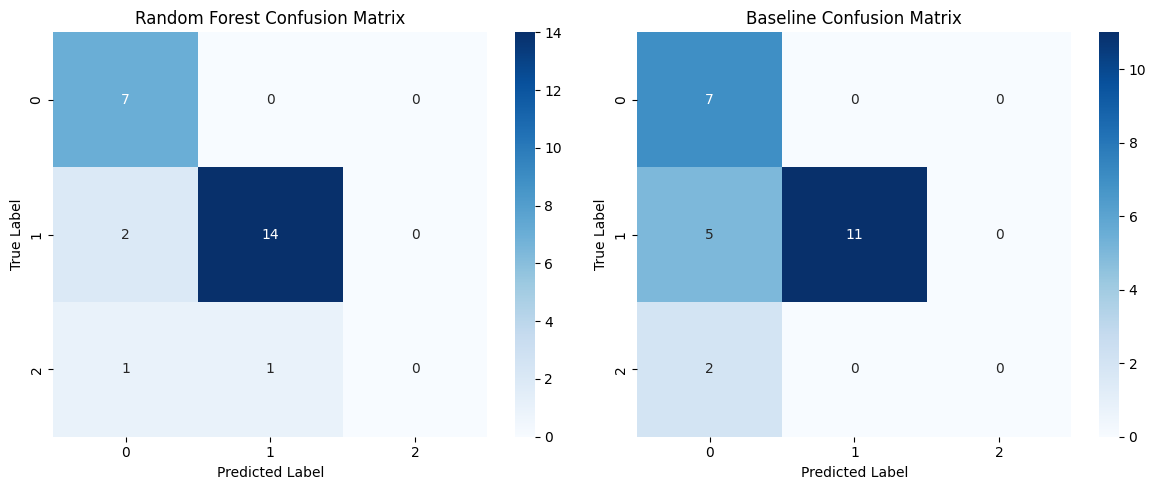

In [78]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest Confusion Matrix
sns.heatmap(rf_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Baseline Confusion Matrix
sns.heatmap(baseline_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Baseline Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

